In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import pi, cos, sin # used for HoF
from scipy.ndimage import uniform_filter # used for hoF
from numpy.lib.scimath import sqrt # used for hoF
from numpy import arctan2 # used for hoF

from sklearn import svm

import math
import numpy as np
import datetime as dt
from collections import deque
import pandas as pd
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
# Check GPU coinfiguration in Colab
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())


Tensorflow version:  2.12.0
/device:GPU:0


In [ ]:
# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MTech AI NUS/PM ITSS/')
!ls
directoryName = 'Dataset'

'2D_CNN Model -Diving Dataset.ipynb'   model_2D1.csv   model_2D.h5     VIDEO
'C3D Model - Diving Dataset.ipynb'     model_2D1.h5    model_c3d.csv
 Dataset			       model_2D.csv    model_c3d.h5


In [ ]:
dive_action_labels  = sorted(os.listdir("Dataset"))
print("Dive labels: ", dive_action_labels)

Dive labels:  ['Entry', 'Flight', 'Takeoff']


In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 10000


def extract_frames(video_path):
     frames_list = []
     video = cv2.VideoCapture(video_path)
     while True:
         _,frame = video.read()
         if not _:
             break;
         processed_frame = cv2.resize(frame, (image_height, image_width))/255
         frames_list.append(processed_frame)
     video.release()
     return frames_list
         

def create_dataset():
    features = []
    labels = []
    temp_frames = []

    for index, className in enumerate(dive_action_labels):
        print(f'Extracting Data of Class: {className}')
        files_list = os.listdir(os.path.join(directoryName, className))
        for file_name in files_list:
            video_path = os.path.join(directoryName, className, file_name)
            frames = extract_frames(video_path)
            temp_frames.extend(frames)

        features.extend(random.sample(temp_frames, max_images_per_class))
        labels.extend([index] * max_images_per_class)
        temp_frames.clear()
    features = np.asarray(features)
    labels = np.array(labels)
    return features,labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: Entry
Extracting Data of Class: Flight
Extracting Data of Class: Takeoff


In [ ]:
ohe_labels = to_categorical(labels)
x_train, x_val, y_train, y_val = train_test_split(features, ohe_labels, test_size = 0.3, shuffle = True, random_state = 100)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.2, shuffle = True, random_state = 100)
print('Training Data : %d , Training Labels %d.'% (len(x_train), (len(y_train))))
print('Validation Data : %d , Validation Labels %d.'% (len(x_val), (len(y_val))))
print('Test Data : %d , Test Labels %d.'% (len(x_test), (len(y_test))))

Training Data : 21000 , Training Labels 21000.
Validation Data : 7200 , Validation Labels 7200.
Test Data : 1800 , Test Labels 1800.


In [ ]:
#Adam optimizer
optim = tf.keras.optimizers.Adam(0.0001)
def create_model():

    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation = 'softmax'))
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    # Printing the models summary
    model.summary()
 
    return model
 
 
# Calling the create_model method
model_CNN = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

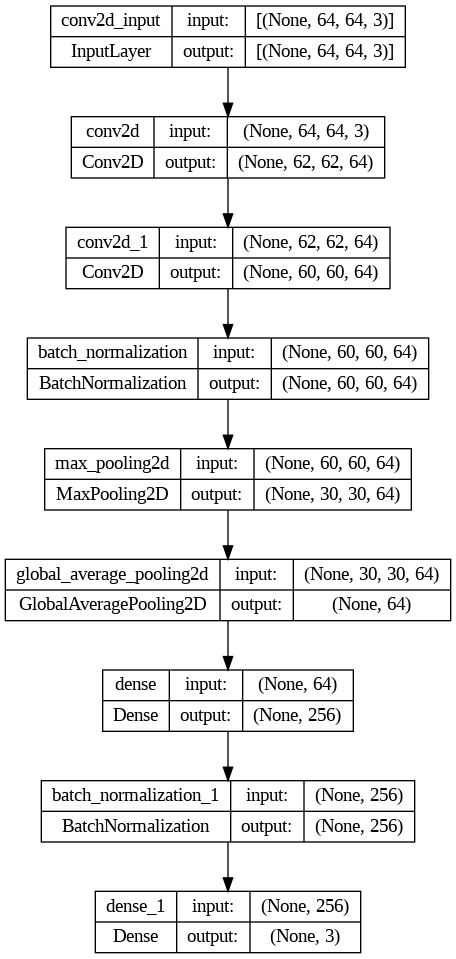

In [4]:
tf.keras.utils.plot_model(model_CNN, to_file='model_1.png', show_shapes=True,show_layer_names=True,)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_2D.h5', save_best_only=True, monitor='val_accuracy', mode='max',restore_best_weights=True)

#Callback to stop training if the metric value doesnt change for 6 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=6, mode='max',restore_best_weights=True)

csv_logger      = CSVLogger('model_2D.csv')

In [ ]:
history = model_CNN.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=50, verbose=2, shuffle=True,
                          callbacks=[checkpoint,early_stop,csv_logger])

Epoch 1/50
657/657 - 23s - loss: 0.4440 - accuracy: 0.8010 - val_loss: 0.5008 - val_accuracy: 0.7842 - 23s/epoch - 35ms/step
Epoch 2/50
657/657 - 9s - loss: 0.3518 - accuracy: 0.8489 - val_loss: 0.4757 - val_accuracy: 0.8112 - 9s/epoch - 13ms/step
Epoch 3/50
657/657 - 9s - loss: 0.3136 - accuracy: 0.8706 - val_loss: 0.3870 - val_accuracy: 0.8483 - 9s/epoch - 14ms/step
Epoch 4/50
657/657 - 9s - loss: 0.2887 - accuracy: 0.8830 - val_loss: 0.8576 - val_accuracy: 0.6844 - 9s/epoch - 13ms/step
Epoch 5/50
657/657 - 9s - loss: 0.2683 - accuracy: 0.8906 - val_loss: 0.2839 - val_accuracy: 0.8835 - 9s/epoch - 14ms/step
Epoch 6/50
657/657 - 9s - loss: 0.2535 - accuracy: 0.8984 - val_loss: 0.2663 - val_accuracy: 0.8921 - 9s/epoch - 13ms/step
Epoch 7/50
657/657 - 9s - loss: 0.2393 - accuracy: 0.9074 - val_loss: 0.2819 - val_accuracy: 0.8939 - 9s/epoch - 14ms/step
Epoch 8/50
657/657 - 9s - loss: 0.2253 - accuracy: 0.9109 - val_loss: 0.3605 - val_accuracy: 0.8451 - 9s/epoch - 13ms/step
Epoch 9/50
657

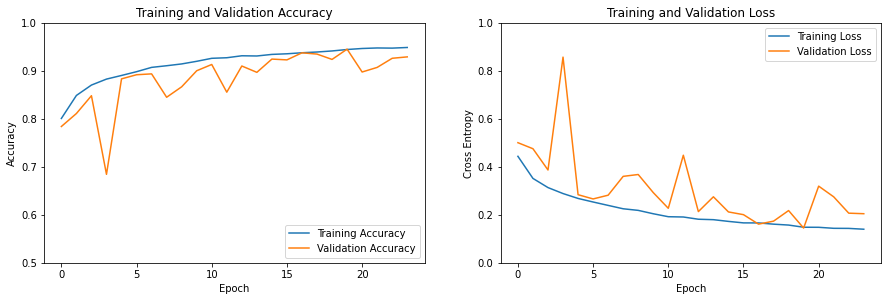

In [ ]:
plt.figure(figsize=(15, 15))
                
records     = pd.read_csv('model_2D.csv')
#Plotting the Accuracy:
plt.subplot(3, 2, 1)
plt.plot(records['accuracy'], label='Training Accuracy')
plt.plot(records['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

#Plotting the Loss:
plt.subplot(3, 2, 2)
plt.plot(records['loss'], label='Training Loss')
plt.plot(records['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model_CNN.load_weights("model_2D.h5")
test_predictions_baseline = model_CNN.predict(x_test)
test_baseline_results = model_CNN.evaluate(x_test,y_test, verbose=0)
test_loss = test_baseline_results[0]
test_acc = (test_baseline_results[1]*100)
print('METRIC VALUES FOR TEST DATASET : \n')
print('LOSS : ', test_loss)
print('ACCURACY : ', test_acc)

57/57 [==============================] - 0s 4ms/step
METRIC VALUES FOR TEST DATASET : 

LOSS :  0.1586027294397354
ACCURACY :  93.88889074325562


In [ ]:
labelname   = ['Entry',          # The label for reporting metrics
               'Flight',
               'Take-Off']
                                                                                # Step 2
predout     = np.argmax(test_predictions_baseline,axis=1)
testout     = np.argmax(y_test,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 93.89%
              precision    recall  f1-score   support

       Entry     0.9701    0.9799    0.9750       597
      Flight     0.9203    0.9023    0.9112       614
    Take-Off     0.9261    0.9355    0.9307       589

    accuracy                         0.9389      1800
   macro avg     0.9388    0.9392    0.9390      1800
weighted avg     0.9387    0.9389    0.9387      1800



In [ ]:
# Load the pre-trained model
model_CNN.load_weights("model_2D.h5")

# Evaluate the deep learning model
y_pred = model_CNN.predict(x_test, verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix
[[585  10   2]
 [ 18 554  42]
 [  0  38 551]]


In [ ]:
model_CNN.load_weights("model_2D.h5")

In [ ]:
image_folder = 'VIDEO/Video_Images/04'
video_name = 'VIDEO/video_05.avi'

images = sorted([img for img in os.listdir(image_folder) if img.endswith(".jpg")])

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
print(frame.shape)
video = cv2.VideoWriter(video_name, 0, 30, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

(256, 455, 3)


In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
    
    predicted_label_list = []
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 30, (original_video_width, original_video_height))
 
    while True: 
 
        # Reading The Frame
        status, frame = video_reader.read() 
 
        if not status:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
 
        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model_CNN.predict(np.expand_dims(normalized_frame, axis = 0))[0]
 
        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
 
        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:
 
            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            print('predicted_labels_probabilities_np : ',predicted_labels_probabilities_np)
 
            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            print('predicted_labels_probabilities_averaged',predicted_labels_probabilities_averaged)
 
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
            predicted_label_list.append(predicted_label)
 
            # Accessing The Class Name using predicted label.
            predicted_class_name = dive_action_labels[predicted_label]
           
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
 
        # Writing The Frame
        video_writer.write(frame)
 
     
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
    return predicted_label_list

In [ ]:
input_video_file_path = 'VIDEO/video_05.avi'
output_video_file_path = 'VIDEO/videoClassification_05.avi'
window_size = 3

predicted_label = predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

1/1 [==============================] - 0s 19ms/step
predicted_labels_probabilities_np :  [[8.4365854e-07 1.6785533e-03 9.9832052e-01]
 [6.2095069e-07 1.2774901e-03 9.9872190e-01]
 [7.6749876e-07 1.5451702e-03 9.9845409e-01]]
predicted_labels_probabilities_averaged [7.4403602e-07 1.5004046e-03 9.9849886e-01]
1/1 [==============================] - 0s 18ms/step
predicted_labels_probabilities_np :  [[6.2095069e-07 1.2774901e-03 9.9872190e-01]
 [7.6749876e-07 1.5451702e-03 9.9845409e-01]
 [1.0192285e-06 1.6527938e-03 9.9834621e-01]]
predicted_labels_probabilities_averaged [8.0255933e-07 1.4918181e-03 9.9850732e-01]
1/1 [==============================] - 0s 21ms/step
predicted_labels_probabilities_np :  [[7.6749876e-07 1.5451702e-03 9.9845409e-01]
 [1.0192285e-06 1.6527938e-03 9.9834621e-01]
 [1.7358166e-06 1.3119149e-03 9.9868637e-01]]
predicted_labels_probabilities_averaged [1.1741813e-06 1.5032929e-03 9.9849558e-01]
1/1 [==============================] - 0s 20ms/step
predicted_labels_prob

In [ ]:
print(len(predicted_label))
print(predicted_label)

103
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(len(predicted_label))
print(predicted_label)

101
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
